In [1]:
import numpy as np
import tensorflow as tf

import load_cifar10
import ops

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm

# 1. Tiny Images of Horses, Dogs, and Planes
(https://www.cs.toronto.edu/~kriz/cifar.html)

CIFAR-10 is a collection of 60,000 tiny 32 x 32 images of horses, dogs, planes, and things.

Includes 6,000 images of each of 10 different images categories.

In [2]:
image_batches, label_batches = load_cifar10.Batches(include_labels=True)
train_image_batches = image_batches[:5]
train_label_batches = label_batches[:5]
train_images = np.concatenate(train_image_batches)
train_labels = np.concatenate(train_label_batches)
test_images = image_batches[5]
test_labels = label_batches[5]

In [3]:
train_labels_one_hot = np.zeros((50000, 10))
train_labels_one_hot[np.arange(50000), train_labels] = 1
test_labels_one_hot = np.zeros((10000, 10))
test_labels_one_hot[np.arange(10000), test_labels] = 1

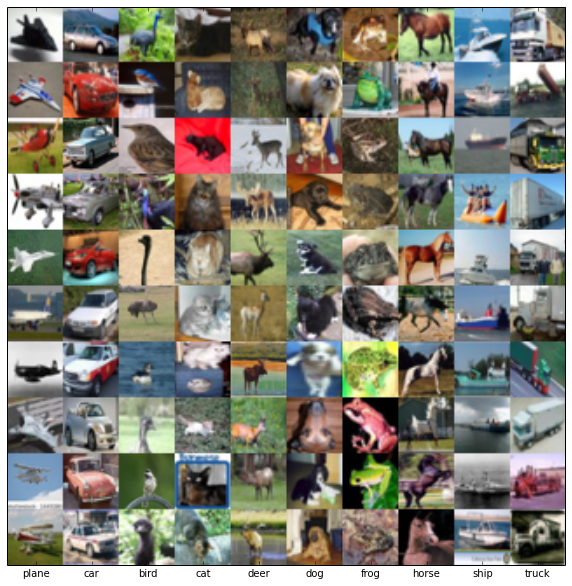

In [4]:
figsize(10, 10)
categories = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
plt.imshow(np.concatenate(
    [train_images[train_labels == x][:10].reshape(320, 32, 3)
     for x in xrange(10)], axis=1))
plt.xticks(
    np.arange(10) * 32 + 16,
    categories)
plt.yticks([])
plt.show()

In [5]:
# TensorFlow uses a session object to execute your computation graph.
try:
    del(sess)
    print "deleted session"
except Exception as e:
    print "no existing session to delete"
sess = tf.InteractiveSession()

no existing session to delete


In [63]:
def Weight(shape, sd=0.02):
    with tf.name_scope("NormedWeight") as ns:
        initial = tf.random_normal(shape, mean=0, stddev=sd)
        V = tf.Variable(initial, name="Direction")
        g = tf.Variable(tf.ones(shape[-1:]), name="Magnitude")
    return V * g

ops.Weight = Weight

In [64]:
def ResNetCell(inp, channels, name):
    inp_channels = int(inp.get_shape()[-1])
    scale = int(channels / inp_channels)
    if inp_channels * scale != channels:
        raise ValueError("Channels must be a whole number multiple of input's channels.")
    with tf.name_scope(name) as ns:
        c1 = ops.ConvLayer(inp, 3, channels, tf.nn.relu, "ResCellConv1")
        c2 = ops.ConvLayer(c1, 3, channels, tf.nn.relu, "ResCellConv2")
        return c2 + tf.tile(inp, [1, 1, 1, scale])

with tf.name_scope("ConvResNetWithDropout") as ns:
    
    # Here we're actualy representing stacks of color images as rank 4 tensors.
    input_images = tf.placeholder(tf.float32, [None, 32, 32, 3], name="InputImages")

    # Convolve and max pool to produce 16 x 16 images with 16 channels
    conv_1 = ops.ConvLayer(input_images, 3, 16, tf.nn.relu, "Conv1")
    mp_1 = tf.nn.max_pool(conv_1, (1, 2, 2, 1), (1, 2, 2, 1), "VALID")

    # A pair of ResNetCells and max pool to produce 8 x 8 images with 32 channels
    res_1 = ResNetCell(mp_1, 32, "Res1")
    res_2 = ResNetCell(res_1, 32, "Res2")
    mp_2 = tf.nn.max_pool(res_2, (1, 2, 2, 1), (1, 2, 2, 1), "VALID")
    
    # A pair of ResNetCells and max pool to produce 4 x 4 images with 64 channels
    res_3 = ResNetCell(mp_2, 64, "Res3")
    res_4 = ResNetCell(res_3, 64, "Res4")
    mp_3 = tf.nn.max_pool(res_4, (1, 2, 2, 1), (1, 2, 2, 1), "VALID")

    # Flatten the representation then run through a fully connected layer with dropout.
    flattened = tf.reshape(mp_3, [-1, 4 * 4 * 64], name="Flatten")
    keep_prob = tf.placeholder(tf.float32)
    dropped = tf.nn.dropout(flattened, keep_prob, name="Dropout")
    W_out, b_out, h_out = ops.HiddenLayer(dropped, [4 * 4 * 64, 10], nonlin=tf.nn.softmax)

    # Calculate accuracy and error
    targets = tf.placeholder(tf.float32, [None, 10], name="TargetLabels")
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(h_out, 1), tf.argmax(targets, 1)), tf.float32))
    err = -tf.reduce_mean(targets * tf.log(h_out))

    # Use the Adam Optimizer with a Learning Rate of 0.001
    train_step = tf.train.AdamOptimizer(0.001).minimize(err)

In [65]:
sess.run(tf.initialize_all_variables())

#### Train the Network

In [ ]:
batch_size = 250
epochs = 40
batches_per_epoch = train_images.shape[0] / batch_size

test_acs = []
test_errs = []
train_acs = []
train_errs = []

# At initialization
test_ac, test_err = sess.run([accuracy, err], feed_dict={
    input_images: test_images,
    targets: test_labels_one_hot,
    keep_prob: 1.0})
test_acs.append((0, test_ac))
test_errs.append((0, test_err))
print "Test Accuracy = {a:.1f}%, Test Error = {e:.5f}".format(
    a=test_ac * 100, e=test_err)

for ep in xrange(epochs):
    
    # Shuffle our training data
    indices = np.arange(len(train_images))
    np.random.shuffle(indices)
    train_images = train_images[indices]
    train_labels_one_hot = train_labels_one_hot[indices]
    
    # Train
    print "\nStarting training epoch {ep}".format(ep=ep)
    for i in xrange(batches_per_epoch):
        start_offset = i * batch_size
        stop_offset = start_offset + batch_size
        _, train_ac, train_err = sess.run(
            [train_step, accuracy, err],
            feed_dict={
                input_images: train_images[start_offset:stop_offset],
                targets: train_labels_one_hot[start_offset:stop_offset],
                keep_prob: 0.5})
        train_acs.append((ep * batches_per_epoch + i, train_ac))
        train_errs.append((ep * batches_per_epoch + i, train_err))
        if (i + 1) % 50 == 0:
            print "Epoch {ep}, batch {ba}: Training Accuracy = {a:.1f}%, Training Error = {e:.5f}".format(
                ep=ep, ba=i, a=train_ac * 100, e=train_err)

    # Test
    test_ac, test_err = sess.run([accuracy, err], feed_dict={
        input_images: test_images,
        targets: test_labels_one_hot,
        keep_prob: 1.0})
    test_acs.append(((ep + 1) * batches_per_epoch, test_ac))
    test_errs.append(((ep + 1) * batches_per_epoch, test_err))
    print "Test Accuracy = {a:.1f}%, Test Error = {e:.5f}".format(
        a=test_ac * 100, e=test_err)
    

Test Accuracy = 10.1%, Test Error = 0.23026

Starting training epoch 0
Epoch 0, batch 49: Training Accuracy = 25.2%, Training Error = 0.20355
Epoch 0, batch 99: Training Accuracy = 30.8%, Training Error = 0.18309
Epoch 0, batch 149: Training Accuracy = 38.0%, Training Error = 0.17854
Epoch 0, batch 199: Training Accuracy = 35.2%, Training Error = 0.16884
Test Accuracy = 39.8%, Test Error = 0.16341

Starting training epoch 1
Epoch 1, batch 49: Training Accuracy = 40.0%, Training Error = 0.16066
Epoch 1, batch 99: Training Accuracy = 42.4%, Training Error = 0.15517
Epoch 1, batch 149: Training Accuracy = 39.2%, Training Error = 0.16009
Epoch 1, batch 199: Training Accuracy = 50.0%, Training Error = 0.14005
Test Accuracy = 45.8%, Test Error = 0.14930

Starting training epoch 2
Epoch 2, batch 49: Training Accuracy = 46.4%, Training Error = 0.15339
Epoch 2, batch 99: Training Accuracy = 45.6%, Training Error = 0.14997
Epoch 2, batch 149: Training Accuracy = 51.2%, Training Error = 0.14021
E

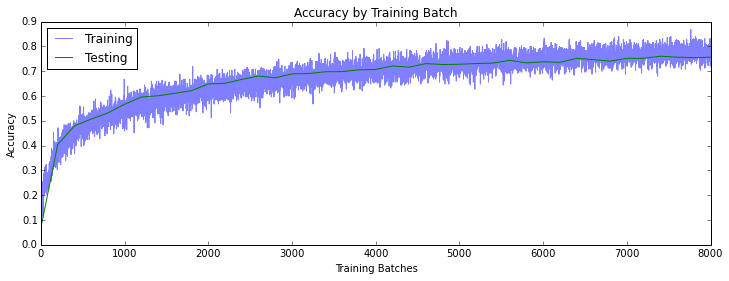

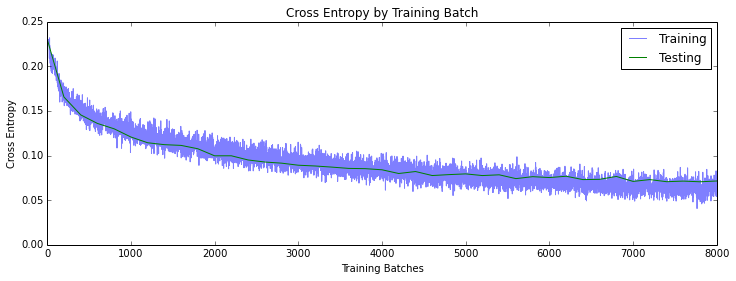

In [37]:
figsize(12, 4)
plt.plot(*zip(*train_acs), alpha=0.5, label="Training")
plt.plot(*zip(*test_acs), label="Testing")
plt.xlabel("Training Batches")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("Accuracy by Training Batch")
plt.show()

plt.plot(*zip(*train_errs), alpha=0.5, label="Training")
plt.plot(*zip(*test_errs), label="Testing")
plt.xlabel("Training Batches")
plt.ylabel("Cross Entropy")
plt.legend(loc="best")
plt.title("Cross Entropy by Training Batch")
plt.show()

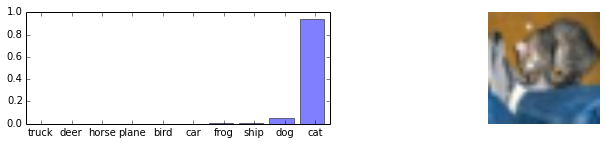

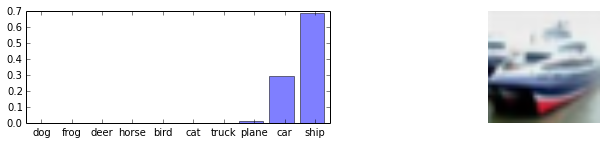

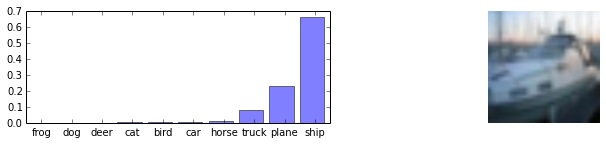

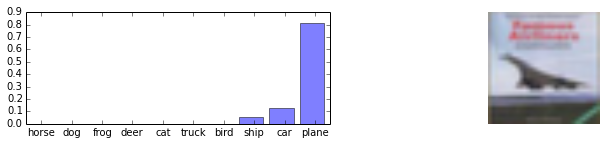

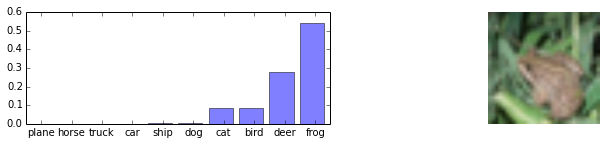

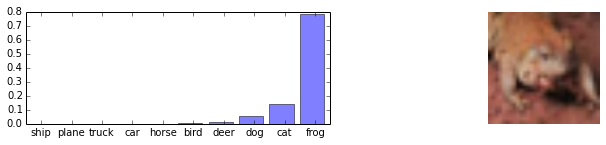

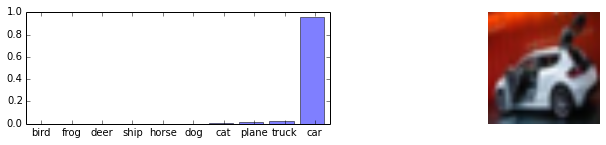

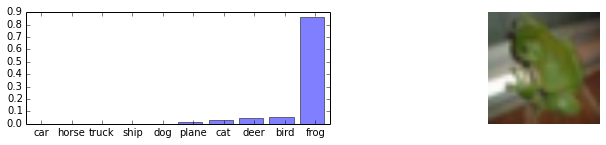

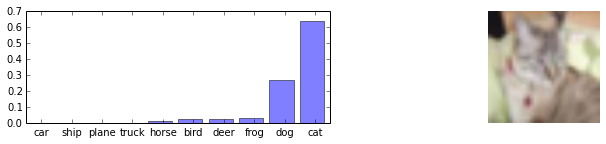

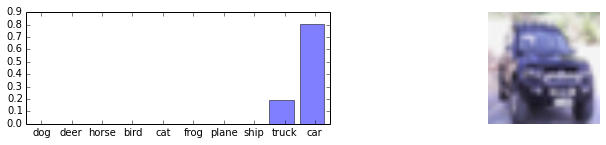

In [41]:
figsize(12, 2)
for i in xrange(10):
    _, (ax0, ax1) = plt.subplots(1, 2)
    ax1.imshow(test_images[i])
    ax1.axis("off")
    scores, labels = zip(*sorted(zip(
        h_out.eval(feed_dict={
            input_images: test_images[i:i+1],
            keep_prob: 1.0}).reshape(10),
        categories)))
    ax0.bar(np.arange(10), scores, alpha=0.5)
    ax0.set_xticks(np.arange(10) + 0.5)
    ax0.set_xticklabels(labels)
    plt.show()

Using increased depth, shortcut residual connections, and dropout regularization, we get an accuracy of about 76%. Much better!

### Another Quick Way of Visualizing Kernels

Is to find images that maximize their response.

Below, each kernel is represented as a row of images.

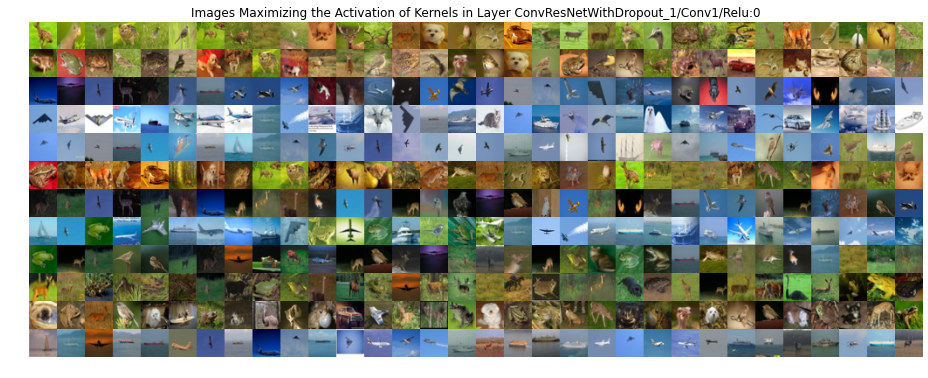

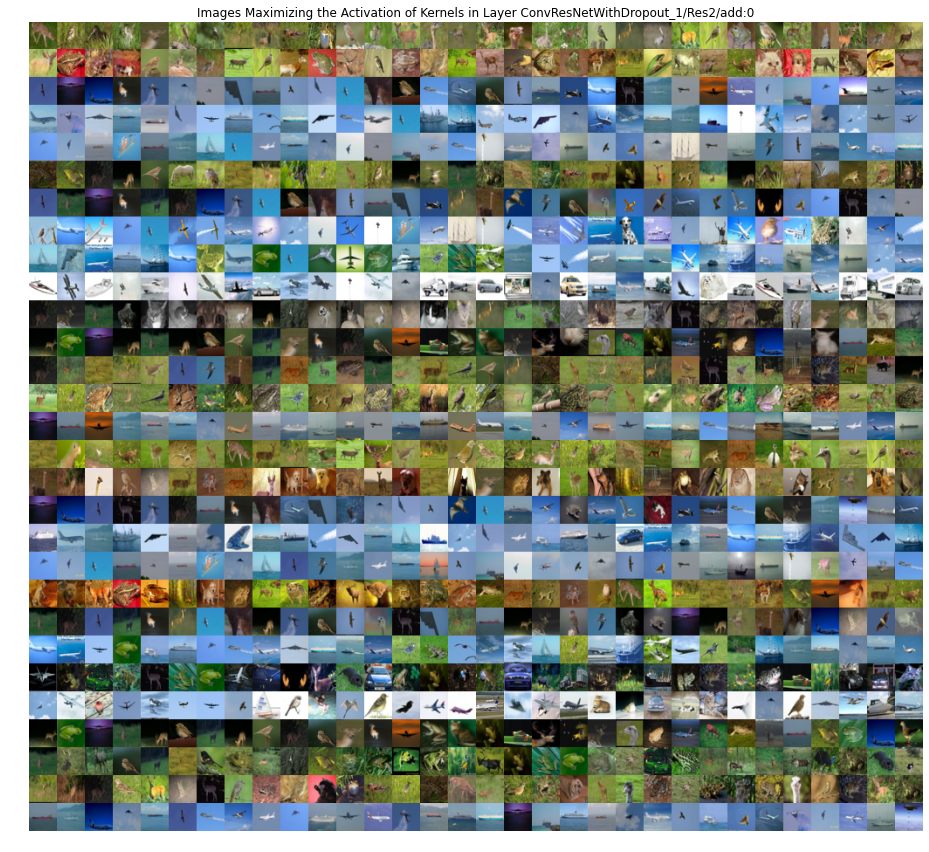

In [95]:
for layer in [conv_1, res_2]:
    kernels = int(layer.get_shape()[-1])
    figsize(16, kernels / 2)
    kernel_scores = tf.reduce_mean(layer, reduction_indices=[1, 2]).eval(
        feed_dict={
            input_images: test_images})
    kernel_means = kernel_scores.mean(axis=0)
    plt.imshow(np.concatenate(
        [np.concatenate(
            list(test_images[kernel_scores[:, x].argsort()[:32]]),
            axis=1)
         for x in xrange(kernels)
         if abs(kernel_means[x]) >= 0.000001]))
    plt.axis("off")
    plt.title("Images Maximizing the Activation of Kernels in Layer {}".format(layer.name))
    plt.show()